# Install Libraries

In [ ]:
!pip install simpletransformers
!pip install --upgrade huggingface_hub

# Import dataset: es (Spanish)

In [ ]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/My Drive/TFG/AuTexTification/subtask_1/es')

import pickle
with open("es_dict_dataset.pkl", "rb") as myFile:
    dict_dataset = pickle.load(myFile)

train_dataset = dict_dataset['train']
val_dataset = dict_dataset['validation']
test_dataset = dict_dataset['test']

Mounted at /content/drive


# Define functions

In [ ]:
# Postprocess the tokens
def postprocess(token):
    with_space = False
    with_break = False
    if token.startswith('Ġ'):
        with_space = True
        token = token[1:]
        # print(token)
    elif token.startswith('â'):
        token = ' '
    elif token.startswith('Ċ'):
        token = ' '
        with_break = True

    token = '-' if token.startswith('â') else token
    token = '“' if token.startswith('ľ') else token
    token = '”' if token.startswith('Ŀ') else token
    token = "'" if token.startswith('Ļ') else token

    return token

In [ ]:
import numpy as np

# Obtain the list of predicted tokens and their respective probabilities of each token
def check_probabilities(in_text, tokenizer, model, topk = 100):
    # Process input
    token_ids = tokenizer(in_text, return_tensors='pt').data['input_ids'][0]
    token_ids = torch.concat([start_token, token_ids])

    # Forward through the model
    output = model(token_ids.to(device))
    all_logits = output.logits[:-1].detach().squeeze()
    # Construct target and pred
    all_probs = torch.softmax(all_logits, dim=1)

    y = token_ids[1:]
    # Sort the predictions for each timestep
    sorted_preds = torch.argsort(all_probs, dim=1, descending=True).cpu()
    # [(pos, prob), ...]
    real_topk_pos = list(
        [int(np.where(sorted_preds[i] == y[i].item())[0][0])
          for i in range(y.shape[0])])
    real_topk_probs = all_probs[np.arange(
        0, y.shape[0], 1), y].data.cpu().numpy().tolist()
    real_topk_probs = list(map(lambda x: round(x, 5), real_topk_probs))

    real_topk = list(zip(real_topk_pos, real_topk_probs))
    # [str, str, ...]
    bpe_strings = tokenizer.convert_ids_to_tokens(token_ids[:])

    bpe_strings = [postprocess(s) for s in bpe_strings]

    topk_prob_values, topk_prob_inds = torch.topk(all_probs, k=topk, dim=1)

    pred_topk = [list(zip(tokenizer.convert_ids_to_tokens(topk_prob_inds[i]),
                          topk_prob_values[i].data.cpu().numpy().tolist()
                          )) for i in range(y.shape[0])]
    pred_topk = [[(postprocess(t[0]), t[1]) for t in pred] for pred in pred_topk]


    payload = {'bpe_strings': bpe_strings,
                'real_topk': real_topk,
                'pred_topk': pred_topk}
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return payload

In [ ]:
# Highlight each token in the text and classify it with respect to the given threshold (ratio)
def color_text(text, payload, ratio):
    colored_text = ''
    l = len(text)
    count = {}
    count['green'] = 0
    count['yellow'] = 0
    count['purple'] = 0
    count['red'] = 0
    pred = 0 # default class: generated

    # Highlight of colors
    for word in range(len(text)):
        if 0 <= payload['real_topk'][word][0] < 10:
            colored_text += '\033[48;2;204;255;204m' + text[word] + '\033[0m' + ' '  # Pastel green
            count['green'] += 1
        elif 10 <= payload['real_topk'][word][0] < 100:
            colored_text += '\033[48;2;255;255;153m' + text[word] + '\033[0m' + ' '  # Pastel yellow
            count['yellow'] += 1
        elif 100<= payload['real_topk'][word][0] < 1000:
            colored_text += '\033[48;2;204;153;255m' + text[word] + '\033[0m' + ' '  # Pastel purple
            count['purple'] += 1
        elif payload['real_topk'][word][0] > 1000:
            colored_text += '\033[48;2;255;153;153m' + text[word] + '\033[0m' + ' '  # Pastel red
            count['red'] += 1
    # print('Count: ', count['green'], 'Text length: ', l)

    # Classification
    if count['green'] > l*ratio:
      return colored_text, pred
    else:
      pred = 1 # human
      return colored_text, pred

In [ ]:
# Main function
def classify_text(in_text, tokenizer, model, ratio):
  # Tokenize input text
  tokens = tokenizer.tokenize(in_text)

  # Filter out special tokens and convert tokens to string
  text = [postprocess(token) for token in tokens if not tokenizer.special_tokens_map.get(token)]

  # Obtain probabilities
  payload = check_probabilities(in_text, tokenizer, model)

  # Color the text
  colored_text, pred = color_text(text, payload, ratio)

  # print('Pred: ', pred)
  # print(colored_text)
  return colored_text, pred

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute evaluation metrics
def test_model(test_dataset, tokenizer, model, ratio):
  # All texts
  texts = test_dataset['text']
  real_labels = test_dataset['label'] # real labels

  pred_labels = []
  for text in texts:
      colored_text, pred = classify_text(text, tokenizer, model, ratio)
      pred_labels.append(pred)

  # Calculate TP, FP, FN counts
  TP = sum(pred == 1 and real == 1 for pred, real in zip(pred_labels, real_labels))
  FP = sum(pred == 1 and real == 0 for pred, real in zip(pred_labels, real_labels))
  FN = sum(pred == 0 and real == 1 for pred, real in zip(pred_labels, real_labels))

  # Calculate precision, recall, and F1-score
  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1 = 2 * (precision * recall) / (precision + recall)

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)

  # Show the precision, recall, and f1-score of the predictions
  LABELS = ['generated', 'human']  # 'generated': 0, 'human': 1
  print(classification_report(y_true=real_labels, y_pred=pred_labels, target_names=LABELS, digits=4))

  # Confusion Matrix
  print(confusion_matrix(real_labels, pred_labels))
  disp=ConfusionMatrixDisplay.from_predictions(real_labels, pred_labels, cmap=plt.cm.Blues)

# GPT-2

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access model and tokenizer
gpt2 = AutoModelForCausalLM.from_pretrained("gpt2").to(device)
tokenizer_gpt2 = AutoTokenizer.from_pretrained("gpt2")
gpt2.eval()
start_token = tokenizer_gpt2(tokenizer_gpt2.bos_token, return_tensors='pt').data['input_ids'][0]

# Threshold values
for ratio in [1/4, 1/3]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2, gpt2, ratio)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RATIO:  0.25
Precision: 0.7790697674418605
Recall: 0.007511210762331838
F1-score: 0.014878969575838329
              precision    recall  f1-score   support

   generated     0.5583    0.9983    0.7161     11209
       human     0.7791    0.0075    0.0149      8920

    accuracy                         0.5592     20129
   macro avg     0.6687    0.5029    0.3655     20129
weighted avg     0.6561    0.5592    0.4054     20129

[[11190    19]
 [ 8853    67]]
RATIO:  0.3333333333333333
Precision: 0.8269896193771626
Recall: 0.02679372197309417
F1-score: 0.05190574438049734
              precision    recall  f1-score   support

   generated     0.5624    0.9955    0.7188     11209
       human     0.8270    0.0268    0.0519      8920

    accuracy                         0.5662     20129
   macro avg     0.6947    0.5112    0.3854     20129
weighted avg     0.6797    0.5662    0.4233     20129

[[11159    50]
 [ 8681   239]]
RATIO:  0.5


In [ ]:
# Threshold values
for ratio in [2/3, 3/4, 5/6]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2, gpt2, ratio)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RATIO:  0.6666666666666666
Precision: 0.4552833078101072
Recall: 0.9998878923766816
F1-score: 0.6256752016836197
              precision    recall  f1-score   support

   generated     0.9981    0.0480    0.0916     11209
       human     0.4553    0.9999    0.6257      8920

    accuracy                         0.4698     20129
   macro avg     0.7267    0.5239    0.3586     20129
weighted avg     0.7576    0.4698    0.3283     20129

[[  538 10671]
 [    1  8919]]
RATIO:  0.75


# GPT-2-Spanish

special_tokens_map.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RATIO:  0.25
Precision: 0.7616279069767442
Recall: 0.012309716218755873
F1-score: 0.02422785278342889
              precision    recall  f1-score   support

   generated     0.5147    0.9963    0.6788     11190
       human     0.7616    0.0123    0.0242     10642

    accuracy                         0.5167     21832
   macro avg     0.6382    0.5043    0.3515     21832
weighted avg     0.6351    0.5167    0.3597     21832

[[11149    41]
 [10511   131]]


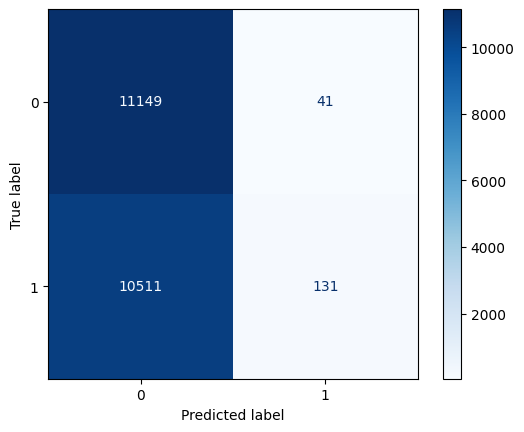

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access model and tokenizer
gpt2_small_spanish = AutoModelForCausalLM.from_pretrained("datificate/gpt2-small-spanish").to(device)
tokenizer_gpt2_small_spanish = AutoTokenizer.from_pretrained("datificate/gpt2-small-spanish")
gpt2_small_spanish.eval()
# Define start token
start_token = tokenizer_gpt2_small_spanish(tokenizer_gpt2_small_spanish.bos_token, return_tensors='pt').data['input_ids'][0]
test_model(test_dataset, tokenizer_gpt2_small_spanish, gpt2_small_spanish, 2/3)

# Threshold value at 1/4
for ratio in [1/4]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2_small_spanish, gpt2_small_spanish, ratio)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/850k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/508k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RATIO:  0.3333333333333333
Precision: 0.8368298368298368
Recall: 0.04024663677130045
F1-score: 0.07679965771740292
              precision    recall  f1-score   support

   generated     0.5654    0.9938    0.7208     11209
       human     0.8368    0.0402    0.0768      8920

    accuracy                         0.5712     20129
   macro avg     0.7011    0.5170    0.3988     20129
weighted avg     0.6857    0.5712    0.4354     20129

[[11139    70]
 [ 8561   359]]


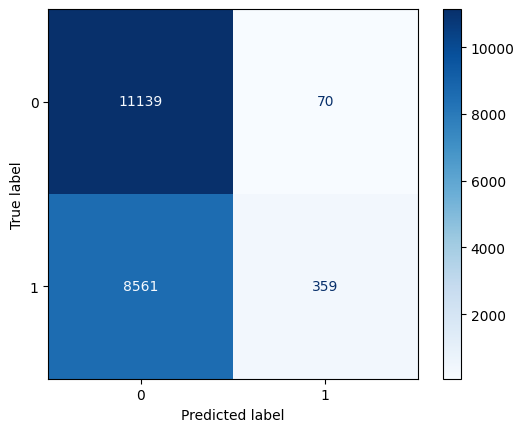

In [ ]:
for ratio in [1/3]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2_small_spanish, gpt2_small_spanish, ratio)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/850k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/508k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RATIO:  0.5
Precision: 0.740625
Recall: 0.3188340807174888
F1-score: 0.4457680250783699
              precision    recall  f1-score   support

   generated     0.6270    0.9111    0.7428     11209
       human     0.7406    0.3188    0.4458      8920

    accuracy                         0.6487     20129
   macro avg     0.6838    0.6150    0.5943     20129
weighted avg     0.6773    0.6487    0.6112     20129

[[10213   996]
 [ 6076  2844]]


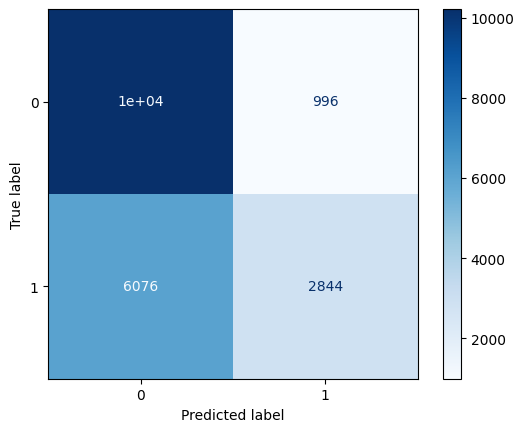

In [ ]:
# Threshold value at 1/2
for ratio in [1/2]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2_small_spanish, gpt2_small_spanish, ratio)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RATIO:  0.6666666666666666
Precision: 0.5520624611345264
Recall: 0.8957399103139013
F1-score: 0.6831103321506433
              precision    recall  f1-score   support

   generated     0.8356    0.4216    0.5605     11209
       human     0.5521    0.8957    0.6831      8920

    accuracy                         0.6317     20129
   macro avg     0.6938    0.6587    0.6218     20129
weighted avg     0.7099    0.6317    0.6148     20129

[[4726 6483]
 [ 930 7990]]


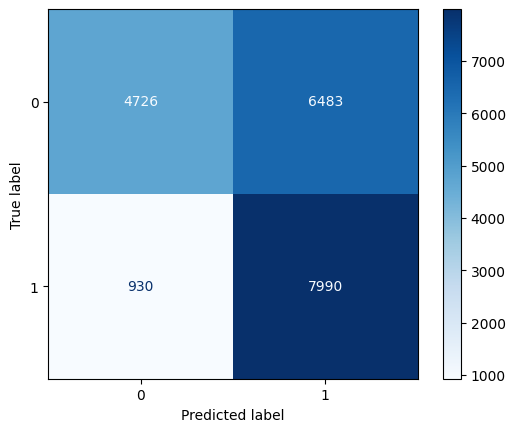

In [ ]:
# Threshold value at 2/3
for ratio in [2/3]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2_small_spanish, gpt2_small_spanish, ratio)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/850k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/508k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RATIO:  0.75
Precision: 0.473366780529462
Recall: 0.9942825112107623
F1-score: 0.6413798090830201
              precision    recall  f1-score   support

   generated     0.9634    0.1197    0.2130     11209
       human     0.4734    0.9943    0.6414      8920

    accuracy                         0.5073     20129
   macro avg     0.7184    0.5570    0.4272     20129
weighted avg     0.7462    0.5073    0.4028     20129

[[1342 9867]
 [  51 8869]]


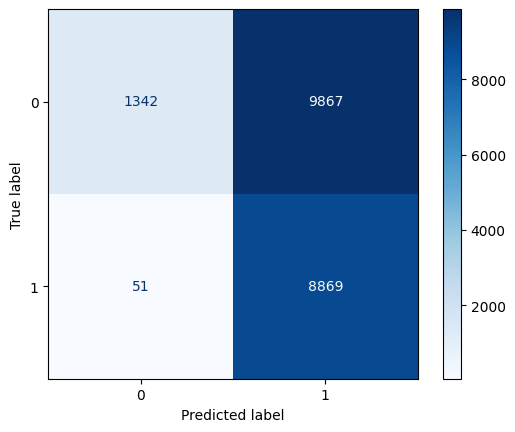

In [ ]:
# Threshold value at 3/4
for ratio in [3/4]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2_small_spanish, gpt2_small_spanish, ratio)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/510M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/850k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/508k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RATIO:  0.8333333333333334
Precision: 0.4471573247768976
Recall: 0.9998878923766816
F1-score: 0.6179588443151113
              precision    recall  f1-score   support

   generated     0.9945    0.0162    0.0320     11209
       human     0.4472    0.9999    0.6180      8920

    accuracy                         0.4521     20129
   macro avg     0.7208    0.5081    0.3250     20129
weighted avg     0.7520    0.4521    0.2916     20129

[[  182 11027]
 [    1  8919]]


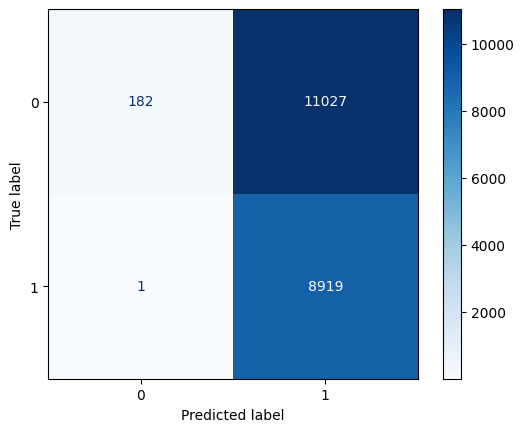

In [ ]:
# Threshold value at 5/6
for ratio in [5/6]:
  print('RATIO: ', ratio)
  test_model(test_dataset, tokenizer_gpt2_small_spanish, gpt2_small_spanish, ratio)

# GPT-2 Medium

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Precision: 0.49783204016430854
Recall: 0.9782511210762331
F1-score: 0.6598608590441621
              precision    recall  f1-score   support

   generated     0.9254    0.2147    0.3486     11209
       human     0.4978    0.9783    0.6599      8920

    accuracy                         0.5531     20129
   macro avg     0.7116    0.5965    0.5042     20129
weighted avg     0.7359    0.5531    0.4865     20129

[[2407 8802]
 [ 194 8726]]


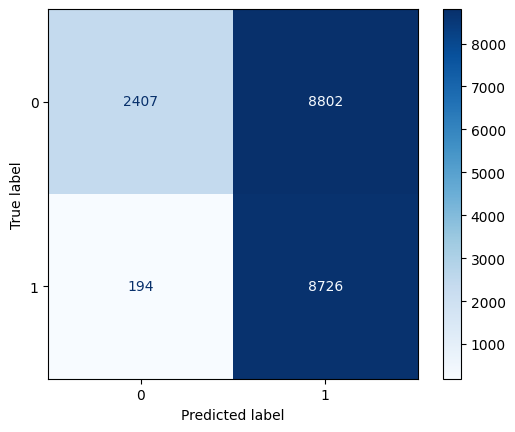

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access model and tokenizer
gpt2_medium = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device)
tokenizer_gpt2_medium = AutoTokenizer.from_pretrained("gpt2-medium")
gpt2_medium.eval()
# Define start token
start_token = tokenizer_gpt2_medium(tokenizer_gpt2_medium.bos_token, return_tensors='pt').data['input_ids'][0]

# Threshold value at 2/3
test_model(test_dataset, tokenizer_gpt2_medium, gpt2_medium, 2/3)

# GPT-2 Large

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Precision: 0.5397163592782476
Recall: 0.908744394618834
F1-score: 0.6772212707297716
              precision    recall  f1-score   support

   generated     0.8407    0.3833    0.5265     11209
       human     0.5397    0.9087    0.6772      8920

    accuracy                         0.6161     20129
   macro avg     0.6902    0.6460    0.6019     20129
weighted avg     0.7073    0.6161    0.5933     20129

[[4296 6913]
 [ 814 8106]]


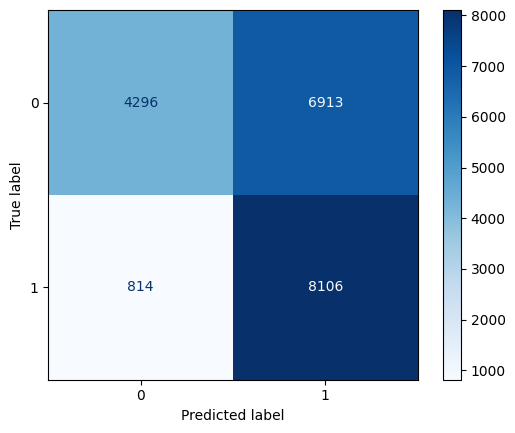

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access model and tokenizer
gpt2_large = AutoModelForCausalLM.from_pretrained("gpt2-large").to(device)
tokenizer_gpt2_large = AutoTokenizer.from_pretrained("gpt2-large")
gpt2_large.eval()
# Define start token
start_token = tokenizer_gpt2_large(tokenizer_gpt2_large.bos_token, return_tensors='pt').data['input_ids'][0]

# Threshold value at 2/3
test_model(test_dataset, tokenizer_gpt2_large, gpt2_large, 2/3)

# GPT-2 XL

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Precision: 0.5887359198998748
Recall: 0.7910313901345292
F1-score: 0.6750538148768237
              precision    recall  f1-score   support

   generated     0.7711    0.5603    0.6490     11209
       human     0.5887    0.7910    0.6751      8920

    accuracy                         0.6625     20129
   macro avg     0.6799    0.6756    0.6620     20129
weighted avg     0.6903    0.6625    0.6605     20129

[[6280 4929]
 [1864 7056]]


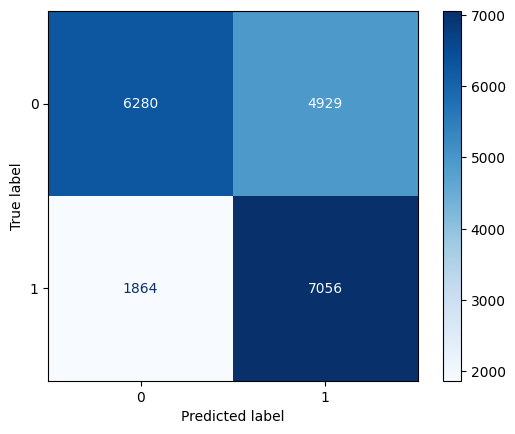

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Access model and tokenizer
gpt2_xl = AutoModelForCausalLM.from_pretrained("gpt2-xl").to(device)
tokenizer_gpt2_xl = AutoTokenizer.from_pretrained("gpt2-xl")
gpt2_xl.eval()
# Define start token
start_token = tokenizer_gpt2_xl(tokenizer_gpt2_xl.bos_token, return_tensors='pt').data['input_ids'][0]

# Threshold value at 2/3
test_model(test_dataset, tokenizer_gpt2_xl, gpt2_xl, 2/3)

# **Conclusions**
**Best Threshold Value:**

The best Generated F1-score is obtained at the 1/2 threshold with 74.28%, while the highest Human F1-score at the threshold 2/3 with 68.31%.
Overall, the optimal threshold that achieves the balanced performance between the Generated and Human categories and highest macro F1-score of 62.18%, is 2/3.


**Best GPT-2 Model:**

The best macro F1-score is achieved with `gpt2-xl` with 66.20%, and with Generated and Human F1-scores of 64.90% and 67.51%, respectively. Moreover, we notice that `gpt2-small-spanish` performs worse regardless of it being trained with Spanish Wikipedia. This could be due to `gpt2-small-spanish` being much smaller in terms of the number of parameters.

Out of 11,209 generated texts, the model correctly identifies 6,280 as generated, but it mistakenly classifies 4,929 as human-written (false positives). For the 8,920 human-written texts, it accurately labels 7,056 as human, while 1,864 are incorrectly classified as generated (false negatives). Although overall the model performs well, it still has room for improvement in distinguishing between generated and human-written texts, especially in reducing false positives and false negatives.

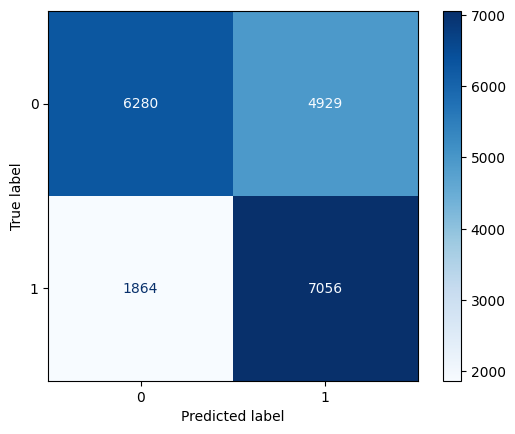